In [1]:
import numpy as np
import torch as pt
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import src.constants as constants
import sys
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.mps import MPS
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState
from src.bf_quantum_state import BFQuantumState

In [2]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [3]:
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()

## Gradient Estimation with Classical Shadows

In [42]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
qubit_num = 14
bond_dim = 30
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [43]:
# 10 min per batch
# now we estimate the gradient by using the derandomized classical shadows
num_of_measurements = np.array([50])
num_of_measurements_per_rot = np.array([10])
batches = 1
some_ratios = np.array([1.0])
meas_methods = np.array(['derandomized'])
errors = np.zeros((np.size(num_of_measurements), batches, np.size(some_ratios)))

for l in range(np.size(meas_methods)):
    if meas_methods[l] == 'derandomized':
        num_of_measurements_per_rot = (num_of_measurements * num_of_measurements_per_rot) / 2
        num_of_measurements = 2 * np.ones(np.size(num_of_measurements))
    for h in range(np.size(some_ratios)):
        param_vec_brute = random_param_vec.clone().detach()
        param_vec_brute.requires_grad_(True)
        mps_brute = MPS.from_tensor_list(tensor_liste_rand)
        mps_brute.from_param_vec(param_vec=param_vec_brute)
        mps_brute.normalise()
        mps_brute.orth_idx = 0
        mps_brute.canonicalise(qubit_num - 1)
        psi = mps_brute.to_state_vector()
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').to_matrix().todense())
        energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
        energy_bf.backward()

        for b in range(0, batches):
            print('starting batch ' + str(b))
            for j in range(np.size(num_of_measurements_per_rot)):
                param_vec_shadow = random_param_vec.clone().detach()
                mps = MPS.from_tensor_list(tensor_liste_rand)
                mps.from_param_vec(param_vec=param_vec_shadow)
                mps.normalise()
                mps.orth_idx = 0
                mps.canonicalise(qubit_num - 1)
                with pt.no_grad():
                    observables = TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').observables_for_energy_estimation()
                    meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(int(num_of_measurements[j]), int(num_of_measurements_per_rot[j]), meas_methods[l], observables)
                energy_shadow_one_basis = pt.zeros(len(meas_procedure))
                grads_energy_one_basis = pt.zeros((len(meas_procedure),param_vec_shadow.size()[0]), dtype=pt.cdouble)
                for n in range(len(meas_procedure)):
                    def ampl_rot(param_vec):
                        mps.from_param_vec(param_vec=param_vec)
                        mps.normalise()
                        amplis = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).amplitude(pt.tensor(meas_outcomes[n]))
                        return pt.cat((pt.real(amplis), pt.imag(amplis)))
                    ampl_gradients = pt.autograd.functional.jacobian(ampl_rot, param_vec_shadow, vectorize=True)
                    amplitudes = ampl_rot(param_vec_shadow)
                    ampl_grads = ampl_gradients[0:len(meas_outcomes[n]),:] + 1j * ampl_gradients[len(meas_outcomes[n]):,:]
                    ampl = amplitudes[0:len(meas_outcomes[n])] + 1j * amplitudes[len(meas_outcomes[n]):]
                    ampl_conj_grads = ampl_gradients[0:len(meas_outcomes[n]),:] - 1j * ampl_gradients[len(meas_outcomes[n]):,:]
                    ampl_conj = amplitudes[0:len(meas_outcomes[n])] - 1j * amplitudes[len(meas_outcomes[n]):]

                    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
                    energies_shadow = []
                    shadow_grads = pt.zeros((len(measurements), param_vec_shadow.size()[0]), dtype=pt.cdouble)
                    for m in range(len(measurements)):
                        num_times_measured = probs[n][m] * num_of_measurements_per_rot[j]
                        energies_shadow.append(TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').energy_shadow_mps_modified(measurements[m], meas_methods[l]) * num_times_measured)
                        shadow_grads[m, :] = energies_shadow[m] *((ampl_grads[m,:] / ampl[m]) + (ampl_conj_grads[m,:] / ampl_conj[m]))
                    energy_shadow_one_basis[n] = pt.sum(pt.tensor(energies_shadow)) / num_of_measurements_per_rot[j]
                    grads_energy_one_basis[n, :] = pt.sum(shadow_grads, dim=0) / num_of_measurements_per_rot[j]
                # compute energy estimate of shadows
                energy_shadow = pt.mean(energy_shadow_one_basis)
                #compute and normalize grad
                grad_energy_shadow = pt.mean(grads_energy_one_basis, dim=0)
                grad_energy_shadow = grad_energy_shadow / pt.linalg.norm(grad_energy_shadow)
                grad_brute = param_vec_brute.grad / pt.linalg.norm(param_vec_brute.grad)

                errors[j,b,h] = pt.linalg.norm((grad_brute - grad_energy_shadow)) / pt.linalg.norm(grad_brute)
                print(errors)

starting batch 0
[[[0.63165434]]]


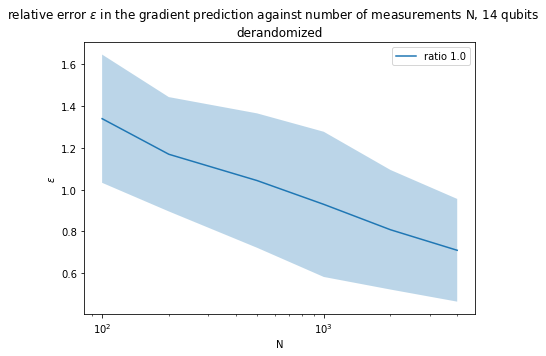

In [134]:
fig, axs = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(7)
fig.suptitle('relative error $\epsilon$ in the gradient prediction against number of measurements N, ' + str(qubit_num) + ' qubits')

num_of_measurements = np.array([10])
num_of_measurements_per_rot = np.array([1, 2, 5, 10, 20, 50, 100, 200, 400])
rel_error_mean = np.mean(errors, axis=1)
rel_error_std = np.std(errors, axis=1)
for h in range(np.size(some_ratios)):
    axs.plot(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,h], label='ratio ' + str(some_ratios[h]))
    axs.fill_between(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,h] - rel_error_std[:,h], rel_error_mean[:,h] + rel_error_std[:,h], alpha=0.3)
    axs.set( xscale='log', xlabel='N', ylabel='$\epsilon$')
    axs.set_title(meas_methods[0])
    axs.legend()

## Gradient Descent with Classical Shadows, comparison to other methods

In [4]:
ratio_h_j = 1.0
qubit_num = 14
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-17.471004054732024


In [156]:
# we do gradient descent with the exact hamiltonian contraction method and see whether we converge to the ground state
#generate a random tensor list
bond_dim = 25
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [157]:
# doing gradient descent using brute force
step_num = 1000
lr = 0.01
random_param_vec_brute = random_param_vec.clone().detach()
random_param_vec_brute.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_brute], lr=lr)

accuracy_brute = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute)
    psi = mps.to_state_vector()
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
    energy.backward()
    accuracy_brute[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i+1) + ' / ' + str(step_num))
    print('accuracy: ' + str(accuracy_brute[i]))
save_direc_brute_grad = Path('data/optim/brute_grad_accuracies.npy')
np.save(save_direc_brute_grad, accuracy_brute)

progress: 1 / 1000
accuracy: 1.791843275230313
progress: 2 / 1000
accuracy: 1.7865466605584148
progress: 3 / 1000
accuracy: 1.7807775768454028
progress: 4 / 1000
accuracy: 1.77446550491848
progress: 5 / 1000
accuracy: 1.7675345747291495
progress: 6 / 1000
accuracy: 1.7599057037802566
progress: 7 / 1000
accuracy: 1.7514994463896467
progress: 8 / 1000
accuracy: 1.7422385857283726
progress: 9 / 1000
accuracy: 1.7320499363540514
progress: 10 / 1000
accuracy: 1.7208657358574218
progress: 11 / 1000
accuracy: 1.7086246619884338
progress: 12 / 1000
accuracy: 1.6952725825446069
progress: 13 / 1000
accuracy: 1.6807631357755808
progress: 14 / 1000
accuracy: 1.6650582742451494
progress: 15 / 1000
accuracy: 1.6481288706073205
progress: 16 / 1000
accuracy: 1.62995536433099
progress: 17 / 1000
accuracy: 1.6105284008069627
progress: 18 / 1000
accuracy: 1.5898494330624209
progress: 19 / 1000
accuracy: 1.5679312458007704
progress: 20 / 1000
accuracy: 1.5447983409665338
progress: 21 / 1000
accuracy: 1.52

In [160]:
save_direc_brute_grad = Path('data/optim/brute_grad_accuracies.npy')
accuracy_brute_loaded = np.load(save_direc_brute_grad, allow_pickle=True)

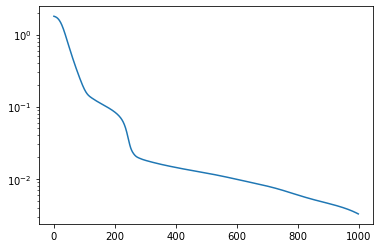

In [161]:
plt.plot(np.arange(0, step_num), accuracy_brute_loaded)
plt.yscale('log')

In [14]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [15]:
# doing gradient descent using shadows
step_num = 500
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([100, 1000, 10000])
meas_method = 'derandomized'
num_unique_ind_shadow = np.zeros((2, np.size(num_of_measurements_per_rot), step_num))
accuracy = np.zeros((np.size(num_of_measurements_per_rot), step_num))
accuracy_un_mod = np.zeros((np.size(num_of_measurements_per_rot), step_num))
for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    random_param_vec_shadow.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
            num_unique_ind_shadow[0, num, i] = len(meas_outcomes[0])
            num_unique_ind_shadow[1, num, i] = len(meas_outcomes[1])
        energies = pt.zeros(len(meas_outcomes))
        energies_un_mod = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_method)
            energies_un_mod[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs[n], meas_method)
        energy_shadow = pt.mean(energies)
        energy_shadow_un_mod = pt.mean(energies_un_mod)
        energy_shadow.backward()
        accuracy[num, i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
        accuracy_un_mod[num, i] = np.abs(energy_shadow_un_mod - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy[num, i]}')

starting meas_num 1000
tensor(13.4058, grad_fn=<MeanBackward0>)
progress: 1 / 500
loss = 1.767317771911621
tensor(13.5387, grad_fn=<MeanBackward0>)
progress: 2 / 500
loss = 1.7749217748641968
tensor(13.6637, grad_fn=<MeanBackward0>)
progress: 3 / 500
loss = 1.782080888748169
tensor(13.3475, grad_fn=<MeanBackward0>)
progress: 4 / 500
loss = 1.763979434967041
tensor(13.2633, grad_fn=<MeanBackward0>)
progress: 5 / 500
loss = 1.7591601610183716
tensor(12.4940, grad_fn=<MeanBackward0>)
progress: 6 / 500
loss = 1.7151298522949219
tensor(12.6162, grad_fn=<MeanBackward0>)
progress: 7 / 500
loss = 1.7221195697784424
tensor(12.4195, grad_fn=<MeanBackward0>)
progress: 8 / 500
loss = 1.7108644247055054
tensor(11.9931, grad_fn=<MeanBackward0>)
progress: 9 / 500
loss = 1.6864559650421143
tensor(11.7601, grad_fn=<MeanBackward0>)
progress: 10 / 500
loss = 1.6731219291687012
tensor(11.4907, grad_fn=<MeanBackward0>)
progress: 11 / 500
loss = 1.6577022075653076
tensor(11.1610, grad_fn=<MeanBackward0>)
pr

KeyboardInterrupt: 

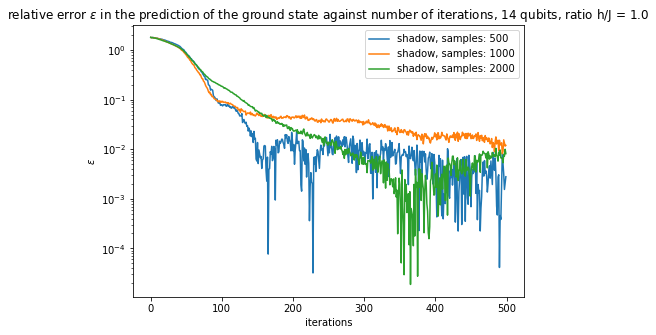

In [50]:
# parameter optimization classical shadows
plt.figure(figsize=(7,5))
for num in range(np.size(num_of_measurements_per_rot)):
    plt.plot(np.arange(0, step_num), accuracy_un_mod[num, :], label='shadow, samples: ' + str(num_of_measurements_per_rot[num]))
plt.title('relative error $\epsilon$ in the prediction of the ground state against number of iterations, ' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j) )
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

Third approach to obtain the gradient:
1.) Measure in the computational basis and obtain indices
2.) obtain the exact amplitudes of these indices
3.) fill these amplitudes/indices into a quantum state
4.) renormalize the quantum state
5.) determine the energy via contraction with Hamiltonian
6.) backpropagation

In [45]:
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [34]:
#sampling brute
step_num = 500
lr = 0.01
num_meas = np.array([1000])
num_unique_ind_brute = np.zeros((np.size(num_meas),step_num))

accuracy_brute_sample = np.zeros((np.size(num_meas), step_num))
for num in range(np.size(num_meas)):
    random_param_vec_brute_sample = random_param_vec.clone().detach()
    random_param_vec_brute_sample.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_brute_sample], lr=lr)
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec = random_param_vec_brute_sample)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            indices, probs, num_samples = MPSQuantumState(qubit_num, mps).measure(num_meas[num])
            num_unique_ind_brute[num, i] = len(indices)
        ampl_direct = MPSQuantumState(qubit_num, mps).amplitude(pt.tensor(indices))
        psi = pt.zeros(2**qubit_num, dtype=pt.cdouble)
        psi[indices] = ampl_direct
        psi = psi / pt.linalg.norm(psi)
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
        energy = psi.conj() @ hamiltonian @ psi
        energy.backward()
        accuracy_brute_sample[num, i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 1 / 500
progress: 2 / 500
progress: 3 / 500
progress: 4 / 500
progress: 5 / 500
progress: 6 / 500
progress: 7 / 500
progress: 8 / 500
progress: 9 / 500
progress: 10 / 500
progress: 11 / 500
progress: 12 / 500
progress: 13 / 500
progress: 14 / 500
progress: 15 / 500
progress: 16 / 500
progress: 17 / 500
progress: 18 / 500
progress: 19 / 500
progress: 20 / 500
progress: 21 / 500
progress: 22 / 500
progress: 23 / 500
progress: 24 / 500
progress: 25 / 500
progress: 26 / 500
progress: 27 / 500
progress: 28 / 500
progress: 29 / 500
progress: 30 / 500
progress: 31 / 500
progress: 32 / 500
progress: 33 / 500
progress: 34 / 500
progress: 35 / 500
progress: 36 / 500
progress: 37 / 500
progress: 38 / 500
progress: 39 / 500
progress: 40 / 500
progress: 41 / 500
progress: 42 / 500
progress: 43 / 500
progress: 44 / 500
progress: 45 / 500
progress: 46 / 500
progress: 47 / 500
progress: 48 / 500
progress: 49 / 500
progress: 50 / 500
progress: 51 / 500
progress: 52 / 500
progress: 53 / 500
pr

In [10]:
num_of_measurements_per_rot = np.array([500])
save_direc_shadow_accuracy = Path('data/optim/shadow_grad_accuracies' + str(num_of_measurements_per_rot[0]) + '.npy')
accuracy_shadow_loaded = np.load(save_direc_shadow_accuracy, allow_pickle=True)
save_direc_brute_grad = Path('data/optim/brute_grad_accuracies.npy')
accuracy_brute_loaded = np.load(save_direc_brute_grad, allow_pickle=True)


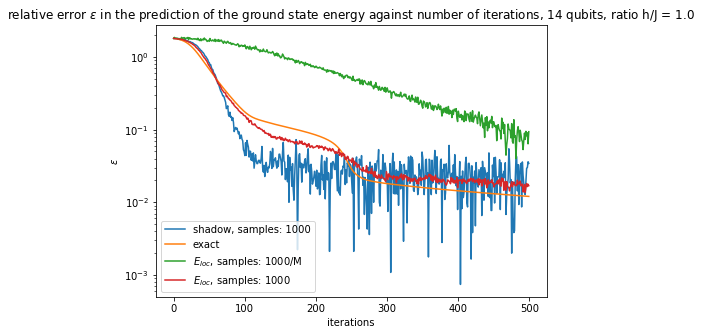

In [12]:
# comparison of all three methods
plt.figure(figsize=(7,5))
num_meas = 1000
step_num = 500

#plt.plot(np.arange(0, step_num), accuracy_brute_sample[num, :], label='reconstruction, samples: ' + str(num_meas[num]))
plt.plot(np.arange(0, step_num), accuracy_shadow_loaded[0][0:step_num], label='shadow, samples: ' + str(num_meas))
plt.plot(np.arange(0, step_num), accuracy_brute_loaded[0:step_num], label='exact')
num_meas = np.array([38, 500])
save_direc_e_loc_accuracy = Path('data/optim/e_loc_grad_accuracies' + str(38.0) + '.npy')
accuracy_e_loc = np.load(save_direc_e_loc_accuracy, allow_pickle=True)
plt.plot(np.arange(0, step_num), accuracy_e_loc[0][0:step_num], label='$E_{loc}$, samples: 1000/M')
save_direc_e_loc_accuracy = Path('data/optim/e_loc_grad_accuracies' + str(1000.0) + '.npy')
accuracy_e_loc = np.load(save_direc_e_loc_accuracy, allow_pickle=True)
plt.plot(np.arange(0, step_num), accuracy_e_loc[0][0:step_num], label='$E_{loc}$, samples: 1000')
plt.title('relative error $\epsilon$ in the prediction of the ground state energy against number of iterations, ' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j))
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

### Accuracy in energy estimation at each iteration step

In [16]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [17]:
# doing gradient descent using shadows
step_num = 500
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([1000])
meas_method = 'derandomized'
num_unique_ind_shadow = np.zeros((2, np.size(num_of_measurements_per_rot), step_num))
accuracy = np.zeros((np.size(num_of_measurements_per_rot), step_num))
accuracy_exact = np.zeros((np.size(num_of_measurements_per_rot), step_num))
accuracy_un_mod = np.zeros((np.size(num_of_measurements_per_rot), step_num))
for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    random_param_vec_shadow.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
            num_unique_ind_shadow[0, num, i] = len(meas_outcomes[0])
            num_unique_ind_shadow[1, num, i] = len(meas_outcomes[1])
        energies = pt.zeros(len(meas_outcomes))
        energies_un_mod = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_method)
            energies_un_mod[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs[n], meas_method)
        energy_shadow = pt.mean(energies)
        energy_shadow_un_mod = pt.mean(energies_un_mod)
        energy_shadow.backward()
        with pt.no_grad():
            psi = mps.to_state_vector()
            hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
            energy_exact = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
            accuracy_exact[num, i] = np.abs(energy_exact - energy_brute) / np.abs(energy_brute)
            accuracy_un_mod[num, i] = np.abs(energy_shadow_un_mod - energy_brute) / np.abs(energy_brute)
        accuracy[num, i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy[num, i]}')

starting meas_num 1000
progress: 1 / 500
loss = 1.7939822673797607
progress: 2 / 500
loss = 1.7849273681640625
progress: 3 / 500
loss = 1.7819719314575195
progress: 4 / 500
loss = 1.7752354145050049
progress: 5 / 500
loss = 1.7583638429641724
progress: 6 / 500
loss = 1.7338154315948486
progress: 7 / 500
loss = 1.7325465679168701
progress: 8 / 500
loss = 1.713905692100525
progress: 9 / 500
loss = 1.6827033758163452
progress: 10 / 500
loss = 1.6464236974716187
progress: 11 / 500
loss = 1.6395056247711182
progress: 12 / 500
loss = 1.6161549091339111
progress: 13 / 500
loss = 1.5979015827178955
progress: 14 / 500
loss = 1.5508226156234741
progress: 15 / 500
loss = 1.5402097702026367
progress: 16 / 500
loss = 1.5232200622558594
progress: 17 / 500
loss = 1.5019477605819702
progress: 18 / 500
loss = 1.4718130826950073
progress: 19 / 500
loss = 1.461069107055664
progress: 20 / 500
loss = 1.4263077974319458
progress: 21 / 500
loss = 1.4177300930023193
progress: 22 / 500
loss = 1.396780133247375

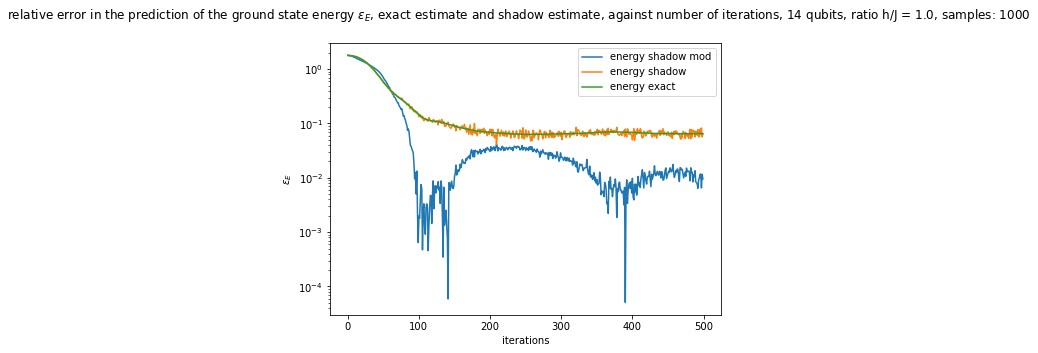

In [19]:
fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(7)
fig.suptitle('relative error in the prediction of the ground state energy $\epsilon_E$, exact estimate and shadow estimate, against number of iterations, ' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j) + ', samples: ' +str(num_of_measurements_per_rot[0]) )

for num in range(np.size(num_of_measurements_per_rot)):
    axs.plot(np.arange(0, step_num), accuracy[num, :], label='energy shadow mod')
    axs.set(yscale = 'log', xlabel='iterations', ylabel='$\epsilon_E$')
    axs.plot(np.arange(0,step_num), accuracy_un_mod[num, :], label='energy shadow')
    axs.plot(np.arange(0,step_num), accuracy_exact[num, :], label='energy exact')
    axs.legend()

### Gradient descent using classical shadows - as many qubits as possible

In [4]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
qubit_num = 22
ratio_h_j = 1.0
save_direc_eigs_max_qubit = Path('data/Diagonal_hamiltonian/eigenvalues_first_max_num_qubits.npy')
energy_dict_max_qubit = np.load(save_direc_eigs_max_qubit, allow_pickle=True)
energy_dict_max_qubit = energy_dict_max_qubit.item()
energy_brute = energy_dict_max_qubit[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
bond_dim = 20
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [5]:
## doing gradient descent using shadows
step_num = 500
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([500])
meas_method = 'derandomized'

accuracy_shadow = np.zeros((np.size(num_of_measurements_per_rot), step_num))

for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
        energy_shadow_one_basis = pt.zeros(len(meas_procedure))
        grads_energy_one_basis = pt.zeros((len(meas_procedure),random_param_vec_shadow.size()[0]), dtype=pt.cdouble)
        for n in range(len(meas_procedure)):
            def ampl_rot(param_vec):
                mps.from_param_vec(param_vec=param_vec)
                mps.normalise()
                amplis = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).amplitude(pt.tensor(meas_outcomes[n]))
                return pt.cat((pt.real(amplis), pt.imag(amplis)))
            ampl_gradients = pt.autograd.functional.jacobian(ampl_rot, random_param_vec_shadow, vectorize=True)
            amplitudes = ampl_rot(random_param_vec_shadow)
            ampl = amplitudes[0:len(meas_outcomes[n])] + 1j * amplitudes[len(meas_outcomes[n]):]
            ampl_grads = ampl_gradients[0:len(meas_outcomes[n]),:] + 1j * ampl_gradients[len(meas_outcomes[n]):,:]
            ampl_conj = amplitudes[0:len(meas_outcomes[n])] - 1j * amplitudes[len(meas_outcomes[n]):]
            ampl_conj_grads = ampl_gradients[0:len(meas_outcomes[n]),:] - 1j * ampl_gradients[len(meas_outcomes[n]):,:]

            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies_shadow = []
            shadow_grads = pt.zeros((len(measurements), random_param_vec_shadow.size()[0]), dtype=pt.cdouble)
            for m in range(len(measurements)):
                num_times_measured = probs[n][m] * num_of_measurements_per_rot[num]
                energies_shadow.append(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements[m], meas_method) * num_times_measured)
                shadow_grads[m, :] = energies_shadow[m] *((ampl_grads[m,:] / ampl[m]) + (ampl_conj_grads[m,:] / ampl_conj[m]))
            energy_shadow_one_basis[n] = pt.sum(pt.tensor(energies_shadow)) / num_of_measurements_per_rot[num]
            grads_energy_one_basis[n, :] = pt.sum(shadow_grads, dim=0) / num_of_measurements_per_rot[num]
        # compute energy estimate of shadows
        energy_shadow = pt.mean(energy_shadow_one_basis)
        #compute and normalize grad
        grad_energy_shadow = pt.mean(grads_energy_one_basis, dim=0)

        accuracy_shadow[num, i] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute)
        random_param_vec_shadow.grad = grad_energy_shadow
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy_shadow[num, i]}')
    save_direc_shadow_accuracy = Path('data/optim/shadow_grad_accuracies' + str(num_of_measurements_per_rot[num]) + '22qubits.npy')
    np.save(save_direc_shadow_accuracy, accuracy_shadow)

starting meas_num 500
progress: 1 / 500
loss = 1.8001821041107178
progress: 2 / 500
loss = 1.8066911697387695
progress: 3 / 500
loss = 1.7845603227615356
progress: 4 / 500
loss = 1.7793530225753784
progress: 5 / 500
loss = 1.7803657054901123
progress: 6 / 500
loss = 1.7928049564361572
progress: 7 / 500
loss = 1.7689385414123535
progress: 8 / 500
loss = 1.776315450668335
progress: 9 / 500
loss = 1.7753028869628906
progress: 10 / 500
loss = 1.780220866203308
progress: 11 / 500
loss = 1.7625740766525269
progress: 12 / 500
loss = 1.7790637016296387
progress: 13 / 500
loss = 1.7604044675827026
progress: 14 / 500
loss = 1.7656116485595703
progress: 15 / 500
loss = 1.7572221755981445
progress: 16 / 500
loss = 1.7738564014434814
progress: 17 / 500
loss = 1.7421789169311523
progress: 18 / 500
loss = 1.752738118171692
progress: 19 / 500
loss = 1.747964859008789
progress: 20 / 500
loss = 1.7397199869155884
progress: 21 / 500
loss = 1.7525933980941772
progress: 22 / 500
loss = 1.742468237876892
pr

KeyboardInterrupt: 

In [6]:
save_direc_shadow_accuracy = Path('data/optim/shadow_grad_accuracies' + str(num_of_measurements_per_rot[num]) + '22qubits.npy')
np.save(save_direc_shadow_accuracy, accuracy_shadow)

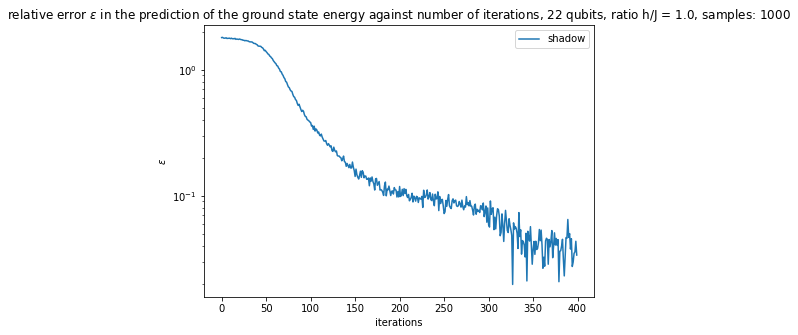

In [10]:
step_num = 400
plt.figure(figsize=(7,5))

plt.plot(np.arange(0, step_num), accuracy_shadow[num, 0:step_num], label='shadow')
plt.title('relative error $\epsilon$ in the prediction of the ground state energy against number of iterations, ' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j)+ ', samples: ' + str(2 * num_of_measurements_per_rot[0]) )
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

## Gradient Descent classical shadows - plot accuracy in gradient prediction at every iteration step

In [21]:
ratio_h_j = 10.0
qubit_num = 14
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-140.3251722276348


In [22]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
bond_dim = 25
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [23]:
# doing gradient descent using shadows
step_num = 500
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([500])
meas_method = 'derandomized'

accuracy_shadow = np.zeros((np.size(num_of_measurements_per_rot), step_num))
accuracy_grad_pred = np.zeros((np.size(num_of_measurements_per_rot), step_num))
accuracy_exact = np.zeros((np.size(num_of_measurements_per_rot), step_num))

hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())

for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
        energy_shadow_one_basis = pt.zeros(len(meas_procedure))
        grads_energy_one_basis = pt.zeros((len(meas_procedure),random_param_vec_shadow.size()[0]), dtype=pt.cdouble)
        for n in range(len(meas_procedure)):
            def ampl_rot(param_vec):
                mps.from_param_vec(param_vec=param_vec)
                mps.normalise()
                amplis = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).amplitude(pt.tensor(meas_outcomes[n]))
                return pt.cat((pt.real(amplis), pt.imag(amplis)))
            ampl_gradients = pt.autograd.functional.jacobian(ampl_rot, random_param_vec_shadow, vectorize=True)
            amplitudes = ampl_rot(random_param_vec_shadow)
            ampl = amplitudes[0:len(meas_outcomes[n])] + 1j * amplitudes[len(meas_outcomes[n]):]
            ampl_grads = ampl_gradients[0:len(meas_outcomes[n]),:] + 1j * ampl_gradients[len(meas_outcomes[n]):,:]
            ampl_conj = amplitudes[0:len(meas_outcomes[n])] - 1j * amplitudes[len(meas_outcomes[n]):]
            ampl_conj_grads = ampl_gradients[0:len(meas_outcomes[n]),:] - 1j * ampl_gradients[len(meas_outcomes[n]):,:]

            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies_shadow = []
            shadow_grads = pt.zeros((len(measurements), random_param_vec_shadow.size()[0]), dtype=pt.cdouble)
            for m in range(len(measurements)):
                num_times_measured = probs[n][m] * num_of_measurements_per_rot[num]
                energies_shadow.append(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements[m], meas_method) * num_times_measured)
                shadow_grads[m, :] = energies_shadow[m] *((ampl_grads[m,:] / ampl[m]) + (ampl_conj_grads[m,:] / ampl_conj[m]))
            energy_shadow_one_basis[n] = pt.sum(pt.tensor(energies_shadow)) / num_of_measurements_per_rot[num]
            grads_energy_one_basis[n, :] = pt.sum(shadow_grads, dim=0) / num_of_measurements_per_rot[num]
        # compute energy estimate of shadows
        energy_shadow = pt.mean(energy_shadow_one_basis)
        #compute and normalize grad
        grad_energy_shadow = pt.mean(grads_energy_one_basis, dim=0)

        accuracy_shadow[num, i] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute)
        param_vec_brute = random_param_vec_shadow.clone().detach()
        mps.from_param_vec(param_vec = param_vec_brute)
        psi = mps.to_state_vector()

        energy_exact = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
        accuracy_exact[num, i] = np.abs(energy_exact.detach() - energy_brute) / np.abs(energy_brute)
        random_param_vec_shadow.grad = grad_energy_shadow
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy_shadow[num, i]}')
        print(f'grad_pred accuracy = {accuracy_grad_pred[num, i]}')
    save_direc_shadow_accuracy = Path('data/optim/shadow_grad_accuracies' + str(num_of_measurements_per_rot[num]) + '10er_ratio_new_run.npy')
    np.save(save_direc_shadow_accuracy, accuracy_shadow)

starting meas_num 500
progress: 1 / 500
loss = 1.9902143478393555
grad_pred accuracy = 0.0
progress: 2 / 500
loss = 1.9883044958114624
grad_pred accuracy = 0.0
progress: 3 / 500
loss = 1.9868508577346802
grad_pred accuracy = 0.0
progress: 4 / 500
loss = 1.9832876920700073
grad_pred accuracy = 0.0
progress: 5 / 500
loss = 1.9768738746643066
grad_pred accuracy = 0.0
progress: 6 / 500
loss = 1.976759910583496
grad_pred accuracy = 0.0
progress: 7 / 500
loss = 1.9749926328659058
grad_pred accuracy = 0.0
progress: 8 / 500
loss = 1.9714008569717407
grad_pred accuracy = 0.0
progress: 9 / 500
loss = 1.959172010421753
grad_pred accuracy = 0.0
progress: 10 / 500
loss = 1.9645596742630005
grad_pred accuracy = 0.0
progress: 11 / 500
loss = 1.966526746749878
grad_pred accuracy = 0.0
progress: 12 / 500
loss = 1.9633054733276367
grad_pred accuracy = 0.0
progress: 13 / 500
loss = 1.955694556236267
grad_pred accuracy = 0.0
progress: 14 / 500
loss = 1.9628493785858154
grad_pred accuracy = 0.0
progress: 1

In [24]:
save_direc_shadow_accuracy = Path('data/optim/shadow_grad_accuracies' + str(num_of_measurements_per_rot[0]) + '10er_ratio_new_run.npy')
accuracy_shadow_loaded = np.load(save_direc_shadow_accuracy, allow_pickle=True)

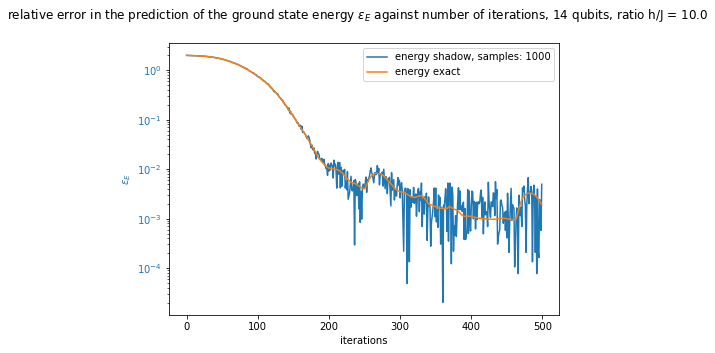

In [25]:
fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(7)
fig.suptitle('relative error in the prediction of the ground state energy $\epsilon_E$ against number of iterations, ' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j) )
step_num = 500

for num in range(np.size(num_of_measurements_per_rot)):
    color = 'tab:blue'
    axs.set(yscale = 'log', xlabel='iterations')
    axs.set_ylabel('$\epsilon_E$', color=color)
    axs.tick_params(axis='y', labelcolor=color)
    axs.plot(np.arange(0, step_num), accuracy_shadow_loaded[num, 0:step_num], label='energy shadow, samples: ' + str(2 * num_of_measurements_per_rot[num]), color = color)
    color = 'tab:orange'
    axs.plot(np.arange(0, step_num), accuracy_exact[num, 0:step_num], label='energy exact', color=color)
    axs.legend()


### local energy vs classical shadows

In [5]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
ratio_h_j = 1.0
qubit_num = 14
bond_dim = 25
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [6]:
param_vec_brute = random_param_vec.clone().detach()
mps_brute = MPS.from_tensor_list(tensor_liste_rand)
mps_brute.from_param_vec(param_vec=param_vec_brute)
mps_brute.normalise()
mps_brute.orth_idx = 0
mps_brute.canonicalise(qubit_num - 1)
psi = mps_brute.to_state_vector()
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
print(energy_bf)

tensor(13.7817-4.9960e-16j, dtype=torch.complex128)


In [6]:
# precomputations for TFIM
observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
coupling_mask = pt.zeros(len(observables), dtype=pt.int)
phase_mask = pt.zeros(len(observables), dtype=pt.int)
num_y = pt.zeros(len(observables), dtype=pt.int)
coeff = pt.zeros(len(observables), dtype=pt.cdouble)
for i in range(len(observables)):
    for observable_1_loc in observables[i]:
        if observable_1_loc[0] == 'X' or observable_1_loc[0] == 'Y':
            coupling_mask[i] = coupling_mask[i] + 2**(qubit_num - 1 - observable_1_loc[1])
        if observable_1_loc[0] == 'Y' or observable_1_loc[0] == 'Z':
            phase_mask[i] = phase_mask[i] + 2**(qubit_num - 1 - observable_1_loc[1])
        if observable_1_loc[0] == 'Y':
            num_y[i] = num_y[i] + 1
        if observable_1_loc[0] == 'X':
            coeff[i] = ratio_h_j
        if observable_1_loc[0] == 'Z':
            coeff[i] = 1

In [7]:
def local_energy(samples, coupling_mask, phase_mask, num_y, coeff, mps):
    basis_idx_new = pt.bitwise_xor(samples.unsqueeze(1).expand(-1, coupling_mask.size()[0]), coupling_mask.unsqueeze(0).expand(samples.size()[0], -1))
    num_ones_y_z = pt.bitwise_and(samples.unsqueeze(1).expand(-1, phase_mask.size()[0]), phase_mask.unsqueeze(0).expand(samples.size()[0], -1))
    mask = 2**pt.arange(qubit_num)
    num_ones_y_z = pt.sum(num_ones_y_z.unsqueeze(-1).bitwise_and(mask).ne(0).byte(), dim=2)
    phases = 1j**num_y.unsqueeze(0).expand(samples.size()[0], -1) * (-1)**num_ones_y_z
    ampl_old = MPSQuantumState(qubit_num, mps).amplitude(samples)
    ampl_new = MPSQuantumState(qubit_num, mps).amplitude(basis_idx_new.reshape(pt.prod(pt.tensor(basis_idx_new.size()))))
    ampl_new = ampl_new.reshape((pt.tensor(basis_idx_new.size())[0],pt.tensor(basis_idx_new.size())[1]))
    exp_vals = ampl_new * phases
    e_loc = pt.einsum('ab,b->a', exp_vals, coeff)
    e_loc = e_loc / ampl_old
    return e_loc

In [21]:
# using local energy
param_vec_e_loc = random_param_vec.clone().detach()
mps_e_loc= MPS.from_tensor_list(tensor_liste_rand)
mps_e_loc.from_param_vec(param_vec=param_vec_brute)
mps_e_loc.normalise()
mps_e_loc.orth_idx = 0
mps_e_loc.canonicalise(qubit_num - 1)
num_meas = np.array([1, 2, 5, 10, 20, 50, 100])
batches = 50
errors_e_loc = np.zeros((np.size(num_meas), batches))
num_samples_e_loc = np.zeros((np.size(num_meas), batches))
for b in range(batches):
    for i in range(np.size(num_meas)):
        samples, probs, num_samples = MPSQuantumState(qubit_num, mps_e_loc).measure(num_meas[i])
        num_samples_e_loc[i, b] = len(samples)
        e_loc = local_energy(pt.tensor(samples), coupling_mask, phase_mask, num_y, coeff, mps_e_loc)
        probabs = num_samples / num_meas[i]
        e_loc_mean = pt.real(pt.sum(e_loc * probabs))
        errors_e_loc[i, b] = pt.abs((energy_bf - e_loc_mean) / energy_bf)

In [22]:
# using unmodified classical shadows
param_vec_shadow = random_param_vec.clone().detach()
mps_shadow = MPS.from_tensor_list(tensor_liste_rand)
mps_shadow.from_param_vec(param_vec=param_vec_brute)
mps_shadow.normalise()
mps_shadow.orth_idx = 0
mps_shadow.canonicalise(qubit_num - 1)
psi_shadow = mps.to_state_vector()
batches = 50
num_meas_shadow = np.array([20, 50, 100, 200, 500, 1000, 2000])
measurement_methods = np.array(['derandomized', 'randomized'])
error_shadow = np.zeros((np.size(num_meas_shadow), batches, np.size(measurement_methods)))
for b in range(batches):
    print('starting batch ' + str(b))
    for l in range(0, 2):
        for n in range(np.size(num_meas_shadow)):
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            measurement_procedure, measurement_index = BFQuantumState(qubit_num, psi_shadow).measurement_shadow(num_meas_shadow[n], measurement_methods[l], observables)
            measurements = conversion_to_prediction_shadow_dict_shape(np.array(measurement_procedure), np.array(measurement_index), qubit_num)
            energy_shadow = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j,
                                                         1, 'open').energy_shadow(None, num_meas_shadow[n], measurement_methods[l], measurements)
            error_shadow[n, b, l] = np.abs((energy_bf - energy_shadow) / energy_bf)

starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9
starting batch 10
starting batch 11
starting batch 12
starting batch 13
starting batch 14
starting batch 15
starting batch 16
starting batch 17
starting batch 18
starting batch 19
starting batch 20
starting batch 21
starting batch 22
starting batch 23
starting batch 24
starting batch 25
starting batch 26
starting batch 27
starting batch 28
starting batch 29
starting batch 30
starting batch 31
starting batch 32
starting batch 33
starting batch 34
starting batch 35
starting batch 36
starting batch 37
starting batch 38
starting batch 39
starting batch 40
starting batch 41
starting batch 42
starting batch 43
starting batch 44
starting batch 45
starting batch 46
starting batch 47
starting batch 48
starting batch 49


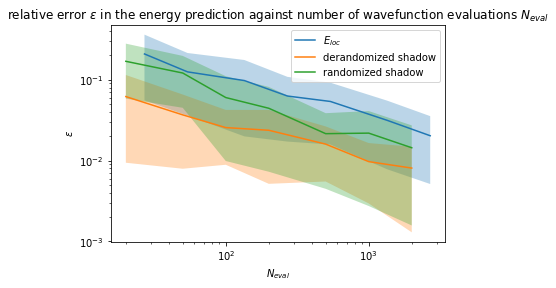

In [23]:
# for E_loc the number of wavefunction evaluations is given by the average number of samples times the number of observables
# for unmodified shadows the number of wavefunction evaluations is given by the number of measurements
num_obs = 2 * qubit_num - 1
num_samples_e_loc_mean = np.mean(num_samples_e_loc, axis=1)
errors_e_loc_mean = np.mean(errors_e_loc, axis=1)
errors_e_loc_std = np.std(errors_e_loc, axis=1)

error_shadow_mean = np.mean(error_shadow, axis=1)
error_shadow_std = np.std(error_shadow, axis=1)

plt.title('relative error $\epsilon$ in the energy prediction against number of wavefunction evaluations $N_{eval}$')
#e_loc
plt.plot(num_obs * num_samples_e_loc_mean, errors_e_loc_mean, label='$E_{loc}$')
plt.fill_between(num_obs * num_samples_e_loc_mean, errors_e_loc_mean - errors_e_loc_std, errors_e_loc_mean + errors_e_loc_std, alpha=0.3)
#shadow
for l in range(0, 2):
    plt.plot(num_meas_shadow, error_shadow_mean[:,l], label=measurement_methods[l] + ' shadow')
    plt.fill_between(num_meas_shadow, error_shadow_mean[:,l] - error_shadow_std[:,l], error_shadow_mean[:,l] + error_shadow_std[:,l], alpha=0.3)
plt.xlabel('$N_{eval}$')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [24]:
# plotting the number of samples on the x-axis, not the number of wavefunction evaluations
# using local energy
param_vec_e_loc = random_param_vec.clone().detach()
mps_e_loc= MPS.from_tensor_list(tensor_liste_rand)
mps_e_loc.from_param_vec(param_vec=param_vec_brute)
mps_e_loc.normalise()
mps_e_loc.orth_idx = 0
mps_e_loc.canonicalise(qubit_num - 1)
num_meas = np.array(([20, 50, 100, 200, 500, 1000, 2000]))
batches = 50
errors_e_loc_samples = np.zeros((np.size(num_meas), batches))
num_samples_e_loc = np.zeros((np.size(num_meas), batches))
for b in range(batches):
    for i in range(np.size(num_meas)):
        samples, probs, num_samples = MPSQuantumState(qubit_num, mps_e_loc).measure(num_meas[i])
        num_samples_e_loc[i, b] = len(samples)
        e_loc = local_energy(pt.tensor(samples), coupling_mask, phase_mask, num_y, coeff, mps_e_loc)
        probabs = num_samples / num_meas[i]
        e_loc_mean = pt.real(pt.sum(e_loc * probabs))
        errors_e_loc_samples[i, b] = pt.abs((energy_bf - e_loc_mean) / energy_bf)

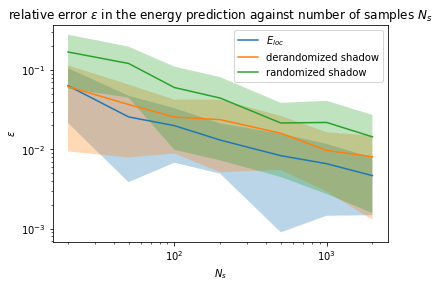

In [25]:
errors_e_loc_mean = np.mean(errors_e_loc_samples, axis=1)
errors_e_loc_std = np.std(errors_e_loc_samples, axis=1)

error_shadow_mean = np.mean(error_shadow, axis=1)
error_shadow_std = np.std(error_shadow, axis=1)

plt.title('relative error $\epsilon$ in the energy prediction against number of samples $N_s$')
#e_loc
plt.plot(num_meas, errors_e_loc_mean, label='$E_{loc}$')
plt.fill_between(num_meas, errors_e_loc_mean - errors_e_loc_std, errors_e_loc_mean + errors_e_loc_std, alpha=0.3)
#shadow
for l in range(0, 2):
    plt.plot(num_meas_shadow, error_shadow_mean[:,l], label=measurement_methods[l] + ' shadow')
    plt.fill_between(num_meas_shadow, error_shadow_mean[:,l] - error_shadow_std[:,l], error_shadow_mean[:,l] + error_shadow_std[:,l], alpha=0.3)
plt.xlabel('$N_s$')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.xscale('log')
plt.legend()

### Gradient with E_loc

In [8]:
step_num = 500
lr = 0.01
num_meas_factor = 5
num_meas = np.ceil(np.array([200]))
#num_meas = np.ceil(np.array([200]))
accuracy_e_loc = np.zeros((np.size(num_meas), step_num))
for num in range(np.size(num_meas)):
    param_vec_e_loc = random_param_vec.clone().detach()
    opt = pt.optim.Adam([param_vec_e_loc], lr=lr)
    for i in range(step_num):

        opt.zero_grad()

        grads_multi_estimates = pt.zeros((num_meas_factor, param_vec_e_loc.size()[0]), dtype=pt.cdouble)
        energy_multi_est = pt.zeros(num_meas_factor, dtype=pt.cdouble)
        for k in range(num_meas_factor):
            mps.from_param_vec(param_vec=param_vec_e_loc)
            mps.normalise()
            mps.orth_idx = 0
            mps.canonicalise(qubit_num - 1)
            with pt.no_grad():
                samples, probs, num_samples = MPSQuantumState(qubit_num, mps).measure(num_meas[num])
            e_loc = local_energy(pt.tensor(samples), coupling_mask, phase_mask, num_y, coeff, mps)
            probabs = num_samples / num_meas[num]
            energy_multi_est[k] = pt.real(pt.sum(e_loc * probabs))

            #computing the gradient

            def ampl(param_vec):
                mps.from_param_vec(param_vec=param_vec)
                mps.normalise()
                amplis = MPSQuantumState(qubit_num, mps).amplitude(pt.tensor(samples))
                return pt.cat((pt.real(amplis), pt.imag(amplis)))
            ampl_gradients = pt.autograd.functional.jacobian(ampl, param_vec_e_loc, vectorize=True)
            amplitudes = ampl(param_vec_e_loc)
            ampl_grads = ampl_gradients[0:len(samples),:] + 1j * ampl_gradients[len(samples):,:]
            ampl = amplitudes[0:len(samples)] + 1j * amplitudes[len(samples):]
            ampl_conj_grads = ampl_gradients[0:len(samples),:] - 1j * ampl_gradients[len(samples):,:]
            ampl_conj = amplitudes[0:len(samples)] - 1j * amplitudes[len(samples):]

            e_loc_grads = pt.zeros((len(samples), param_vec_e_loc.size()[0]), dtype=pt.cdouble)
            for m in range(len(samples)):
                num_times_measured = num_samples[m]
                e_loc_grads[m, :] = e_loc[m] * num_times_measured *((ampl_grads[m,:] / ampl[m]) + (ampl_conj_grads[m,:] / ampl_conj[m]))
            grads_multi_estimates[k, :] = pt.sum(e_loc_grads, dim=0) / num_meas[num]
        e_loc_grad = pt.mean(grads_multi_estimates, dim=0)
        energy = pt.mean(energy_multi_est, dim=0)
        accuracy_e_loc[num, i] = np.abs(energy.item() - energy_brute) / np.abs(energy_brute)
        param_vec_e_loc.grad = e_loc_grad
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print('accuracy: ' + str(accuracy_e_loc[num,i]))
    save_direc_e_loc_accuracy = Path('data/optim/e_loc_grad_accuracies' + str(num_meas[num]*num_meas_factor) + '.npy')
    np.save(save_direc_e_loc_accuracy, accuracy_e_loc)

progress: 1 / 500
accuracy: 1.7959481968507633
progress: 2 / 500
accuracy: 1.7841545721607472
progress: 3 / 500
accuracy: 1.781897301959238
progress: 4 / 500
accuracy: 1.7847287662629763
progress: 5 / 500
accuracy: 1.7738949589194106
progress: 6 / 500
accuracy: 1.766750588953681
progress: 7 / 500
accuracy: 1.7592765005586801
progress: 8 / 500
accuracy: 1.75610450321428
progress: 9 / 500
accuracy: 1.7500059718824583
progress: 10 / 500
accuracy: 1.740194055448762
progress: 11 / 500
accuracy: 1.7426493167116883
progress: 12 / 500
accuracy: 1.7410657158933347
progress: 13 / 500
accuracy: 1.7223125070915963
progress: 14 / 500
accuracy: 1.7231872796526548
progress: 15 / 500
accuracy: 1.6982744146534507
progress: 16 / 500
accuracy: 1.6908977967242265
progress: 17 / 500
accuracy: 1.6716326729706805
progress: 18 / 500
accuracy: 1.657650235812335
progress: 19 / 500
accuracy: 1.646470738845407
progress: 20 / 500
accuracy: 1.633604725189789
progress: 21 / 500
accuracy: 1.624027126457337
progress: 